# Classifying Asteroids as Hazardous

In [32]:
# Imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

## Data Preprocess

### Exploratory Data Analysis

In [33]:
df = pd.read_csv('data/nasa.csv')
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

Looking at the data, we can find columns that are note needed since they are duplicated in different units of measure.
We can also remove identification columns since they don't provide useful information to the problem.

In [35]:
cols_to_drop = [
    # Remove duplicated columns (same data, different units of measure)
    "Est Dia in KM(min)",
    "Est Dia in KM(max)",
    "Est Dia in Miles(min)",
    "Est Dia in Miles(max)",
    "Est Dia in Feet(min)",
    "Est Dia in Feet(max)",
    "Relative Velocity km per hr",
    "Miles per hour",
    "Miss Dist.(Astronomical)",
    "Miss Dist.(lunar)",
    "Miss Dist.(miles)",

    # Remove identification columns
    "Neo Reference ID",
    "Name",
    "Orbit ID",
]

df.drop(cols_to_drop, axis=1, inplace=True)

In [36]:
# Check for missing values
df.isna().sum()

Absolute Magnitude              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Miss Dist.(kilometers)          0
Orbiting Body                   0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination                     0
Asc Node Longitude              0
Orbital Period                  0
Perihelion Distance             0
Perihelion Arg                  0
Aphelion Dist                   0
Perihelion Time                 0
Mean Anomaly                    0
Mean Motion                     0
Equinox                         0
Hazardous                       0
dtype: int64

In [37]:
# Check for duplicated values
df.duplicated().sum()

0

In [38]:
# Encode target variable
label_encoder = LabelEncoder()
df["Hazardous"] = label_encoder.fit_transform(df["Hazardous"])

df.head()

,Absolute Magnitude,Est Dia in M(min),Est Dia in M(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbiting Body,Orbit Determination Date,Orbit Uncertainity,...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,21.6,127.219879,284.472297,1995-01-01,788947200000,6.115834,62753692.0,Earth,2017-04-06 08:36:37,5,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,1
1,21.3,146.067964,326.617897,1995-01-01,788947200000,18.113985,57298148.0,Earth,2017-04-06 08:32:49,3,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,0
2,20.3,231.502122,517.654482,1995-01-08,789552000000,7.590711,7622911.5,Earth,2017-04-06 09:20:19,0,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,1
3,27.4,8.801465,19.680675,1995-01-15,790156800000,11.173874,42683616.0,Earth,2017-04-06 09:15:49,6,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,0
4,21.6,127.219879,284.472297,1995-01-15,790156800000,9.840831,61010824.0,Earth,2017-04-06 08:57:58,1,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,1


In [39]:
# Remove categorical data that is not relevant to the problem (has a single value)
categorical = df.select_dtypes(include="object").columns.tolist()

unique_categorical = [cat for cat in categorical if df[cat].nunique() == 1]
unique_categorical

['Orbiting Body', 'Equinox']

In [40]:
df.drop(columns=['Orbiting Body', 'Equinox'], axis=1, inplace=True)

Having done the preprocessing, we can now proceed to analyze the data.

/tmp/ipykernel_173808/1381795533.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


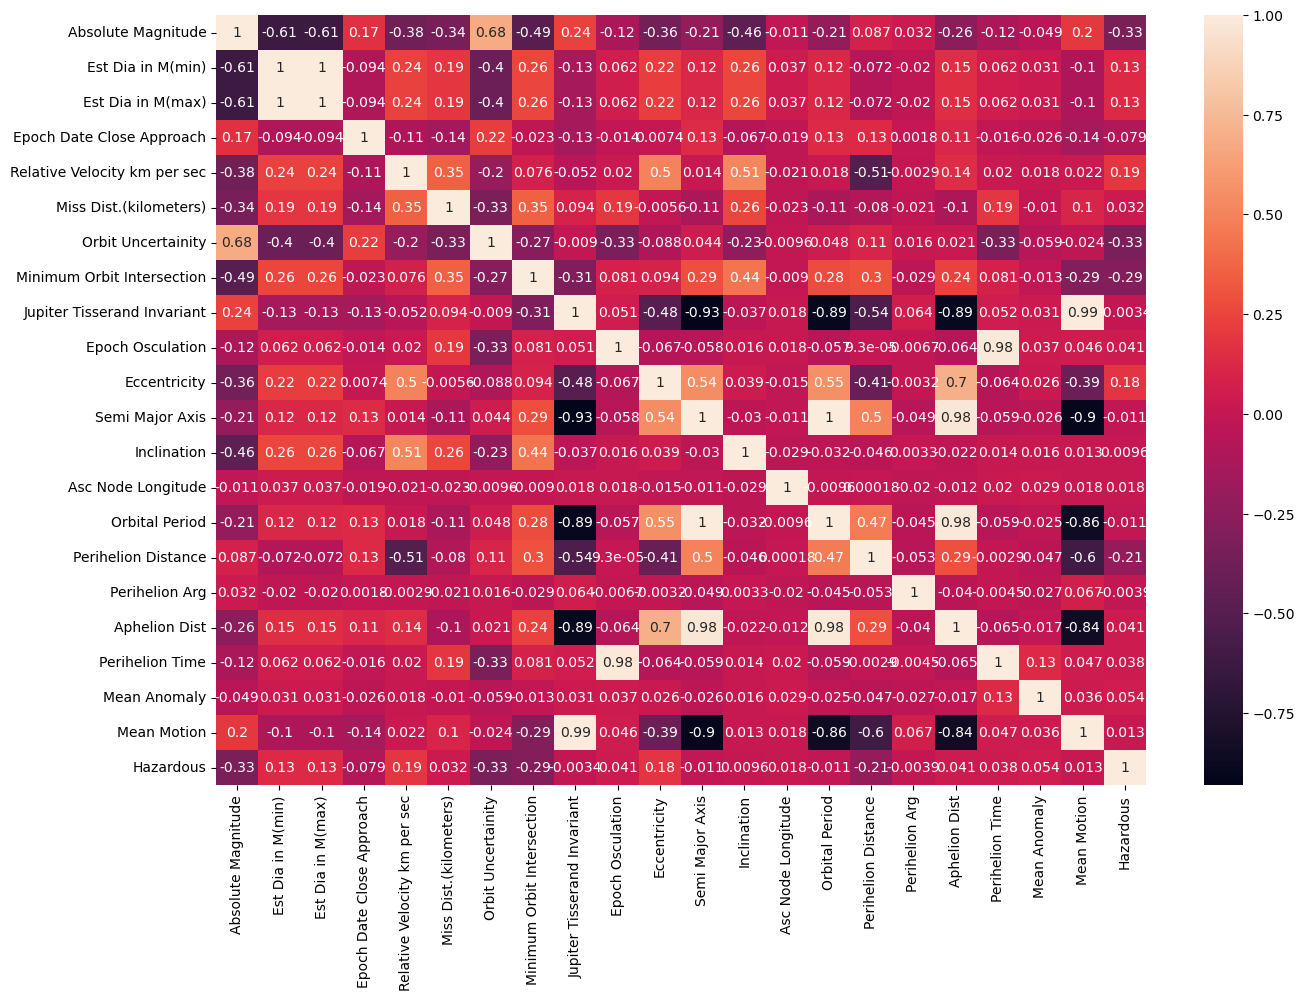

In [41]:
# Correlation matrix

correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sb.heatmap(correlation_matrix, annot=True)
plt.show()

With the heatmap in mind we can see that:

    - The columns `Est Dia in M(min)` and `Est Dia in M(max)` are highly correlated.
    - The columns `Jupiter Tisserand Invariant` and `Mean Motion` are highly correlated.
    - The Columns `Epoch Osculation` and `Perihelion Time` are highly correlated.
    - The columns `Semi Major Axis` and `Orbital Period` are highly correlated.
    - The columns `Semi Major Axis` and `Aphelion Dist` are highly correlated.

In [42]:
# remove highly correlated columns
cols_to_remove = [
    'Est Dia in M(min)',
    'Jupiter Tisserand Invariant',
    'Epoch Osculation',
    'Orbital Period',
    'Aphelion Dist',
]

df.drop(cols_to_remove, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(max)             4687 non-null   float64
 2   Close Approach Date           4687 non-null   object 
 3   Epoch Date Close Approach     4687 non-null   int64  
 4   Relative Velocity km per sec  4687 non-null   float64
 5   Miss Dist.(kilometers)        4687 non-null   float64
 6   Orbit Determination Date      4687 non-null   object 
 7   Orbit Uncertainity            4687 non-null   int64  
 8   Minimum Orbit Intersection    4687 non-null   float64
 9   Eccentricity                  4687 non-null   float64
 10  Semi Major Axis               4687 non-null   float64
 11  Inclination                   4687 non-null   float64
 12  Asc Node Longitude            4687 non-null   float64
 13  Per

In [43]:
# Select numerical columns
numerical = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical.remove('Hazardous')

numerical

['Absolute Magnitude',
 'Est Dia in M(max)',
 'Epoch Date Close Approach',
 'Relative Velocity km per sec',
 'Miss Dist.(kilometers)',
 'Orbit Uncertainity',
 'Minimum Orbit Intersection',
 'Eccentricity',
 'Semi Major Axis',
 'Inclination',
 'Asc Node Longitude',
 'Perihelion Distance',
 'Perihelion Arg',
 'Perihelion Time',
 'Mean Anomaly',
 'Mean Motion']

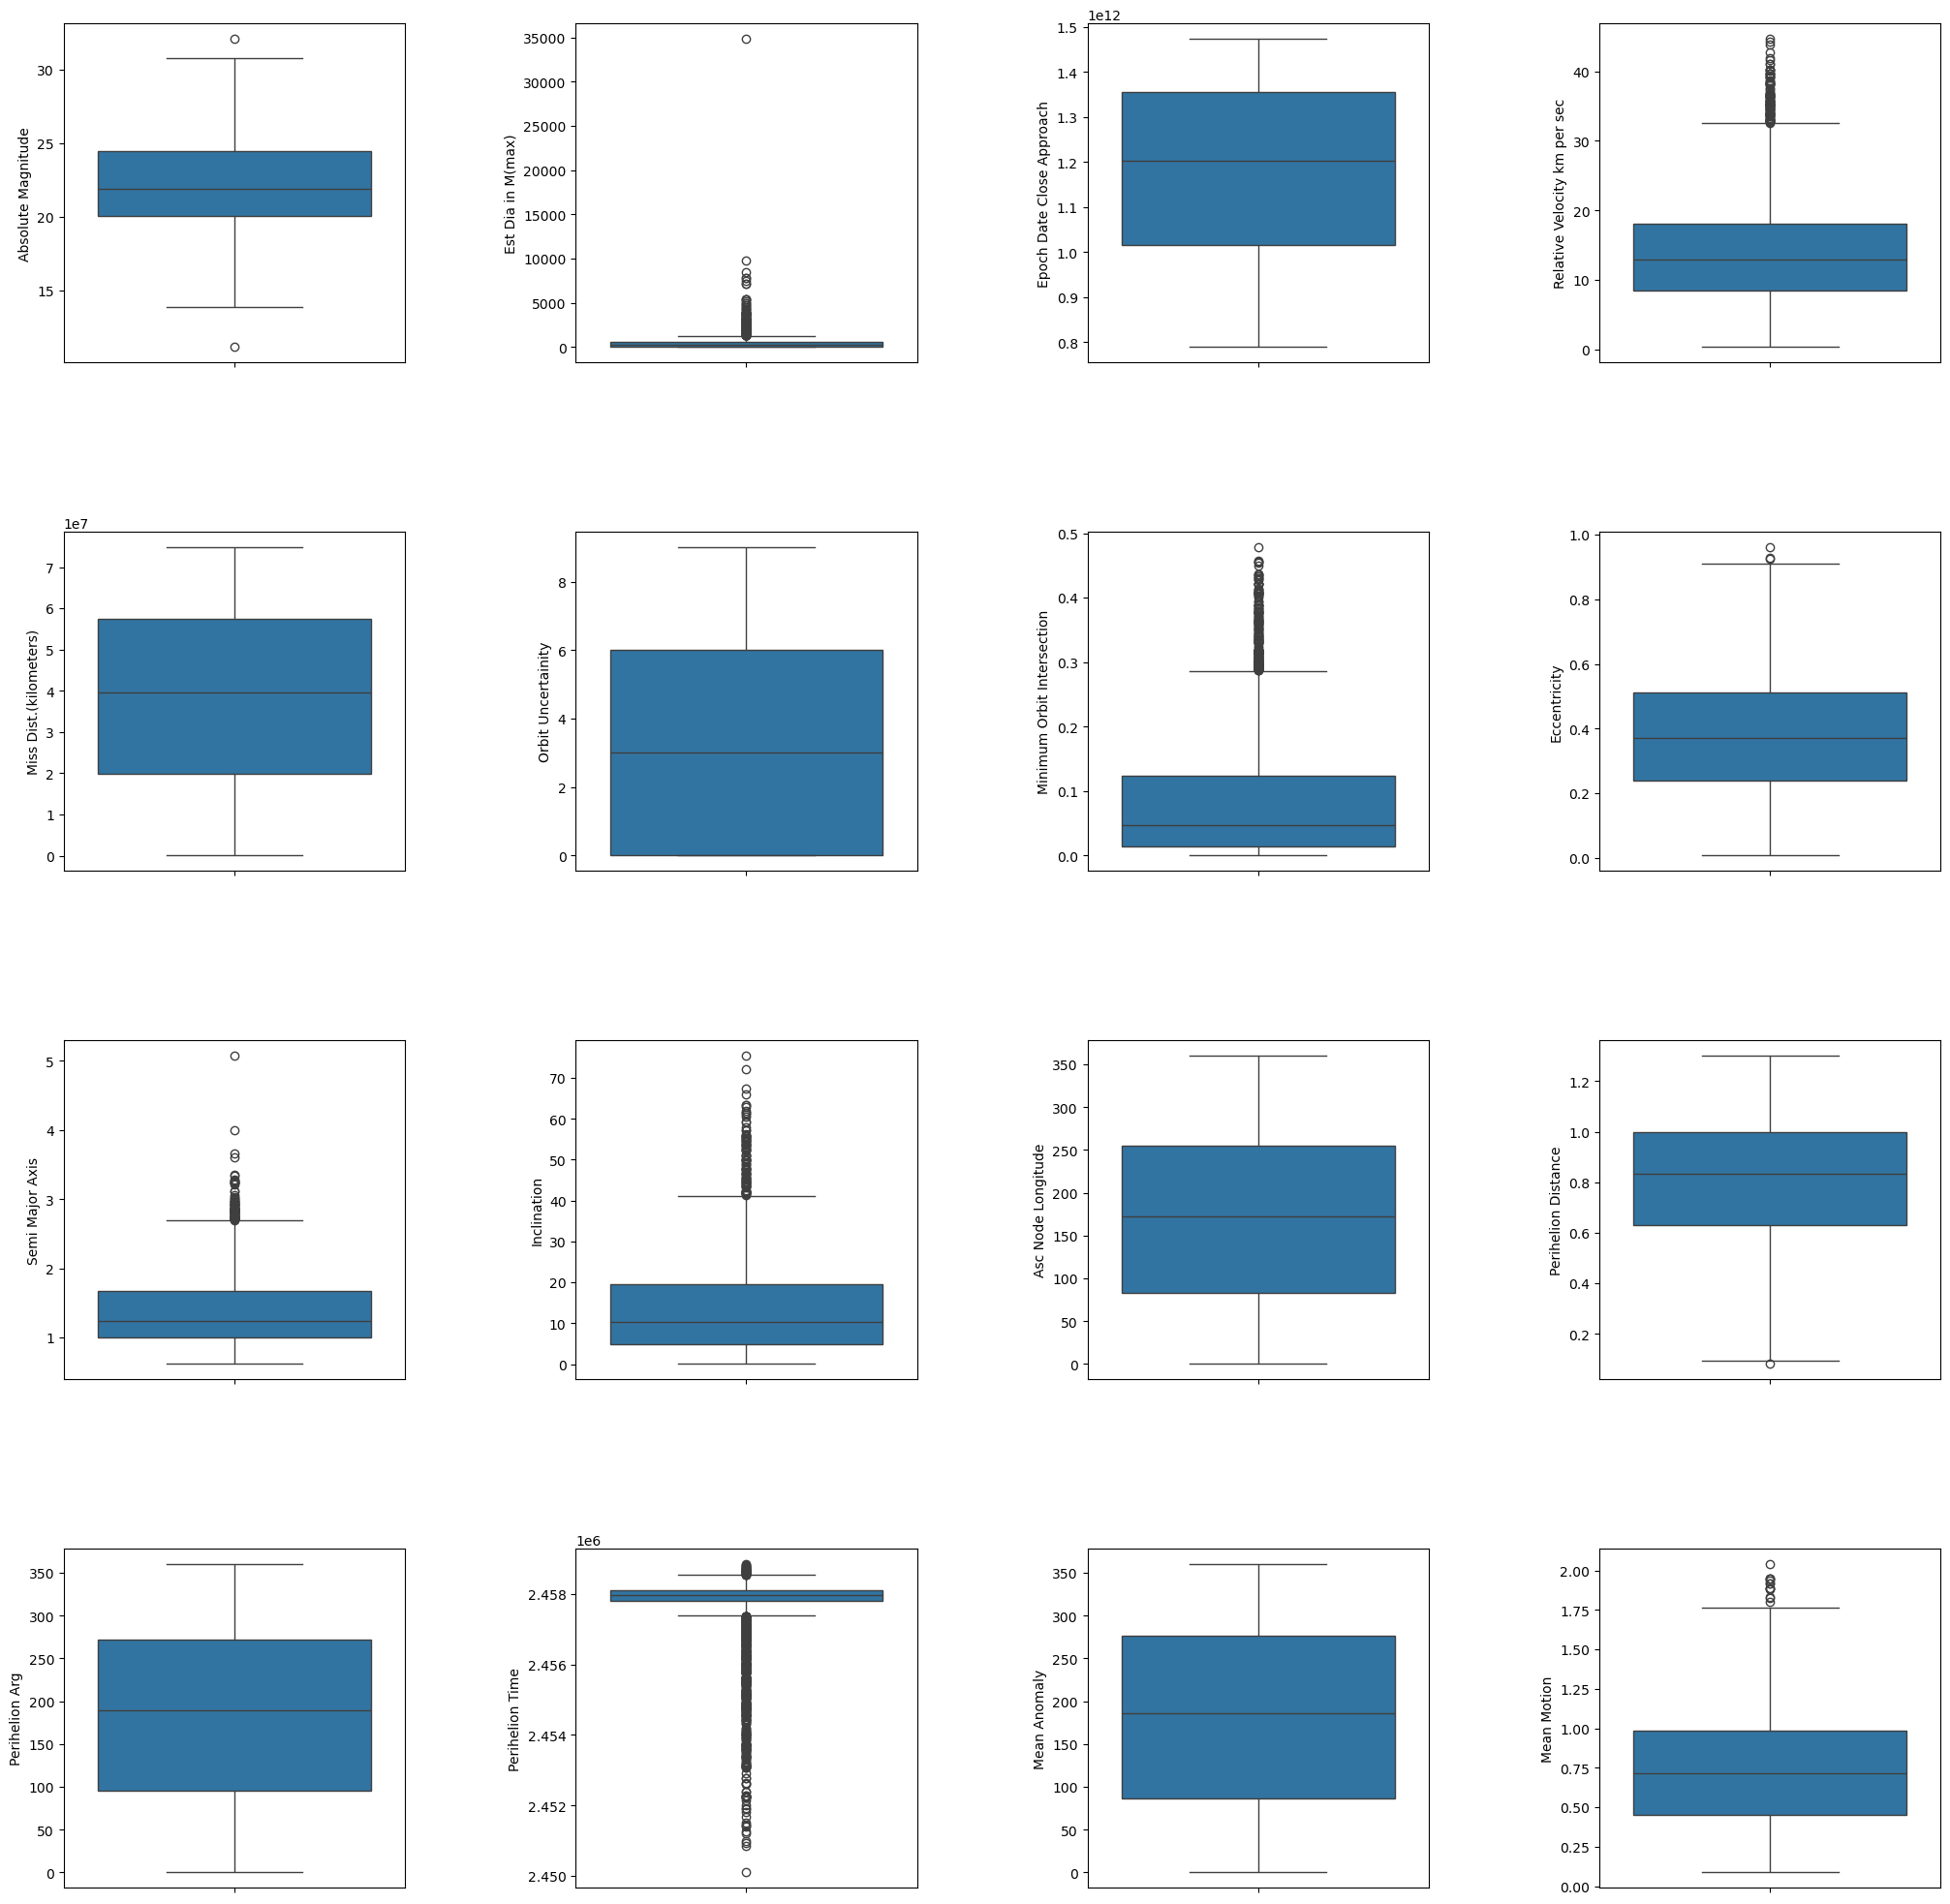

In [44]:
# Plot boxplots for numerical columns

fig, axes = plt.subplots(math.ceil(len(numerical) / 4), 4, figsize=(25, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
axes = axes.ravel()

# for i, col in enumerate(numerical):
#     sb.boxplot(x='Hazardous', y=col, data=df, ax=axes[i])

for col, axis in zip(numerical, axes):
    sb.boxplot(data=df[col], ax=axis)

for i in range(len(numerical), len(axes)):
    fig.delaxes(axes[i])

plt.show()

In [45]:
# Remove outliers

for col in numerical:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df.describe()

,Absolute Magnitude,Est Dia in M(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(kilometers),Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,284.472297,1995-01-01,788947200000,6.115834,62753692.0,2017-04-06 08:36:37,5,0.025282,0.425549,1.407011,6.025981,314.373913,0.808259,57.257470,2.458162e+06,264.837533,0.590551,1
1,21.3,326.617897,1995-01-01,788947200000,18.113985,57298148.0,2017-04-06 08:32:49,3,0.186935,0.351674,1.107776,28.412996,136.717242,0.718200,313.091975,2.457795e+06,173.741112,0.845330,0
2,20.3,517.654482,1995-01-08,789552000000,7.590711,7622911.5,2017-04-06 09:20:19,0,0.043058,0.348248,1.458824,4.237961,259.475979,0.950791,248.415038,2.458120e+06,292.893654,0.559371,1
3,27.4,19.680675,1995-01-15,790156800000,11.173874,42683616.0,2017-04-06 09:15:49,6,0.005512,0.216578,1.255903,7.905894,57.173266,0.983902,18.707701,2.457902e+06,68.741007,0.700277,0
4,21.6,284.472297,1995-01-15,790156800000,9.840831,61010824.0,2017-04-06 08:57:58,1,0.034798,0.210448,1.225615,16.793382,84.629307,0.967687,158.263596,2.457814e+06,135.142133,0.726395,1
